In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.amp as amp
from torch.utils.data import DataLoader
import random
import os
from torchvision import transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# Define paths
DATASET_DIR = r'dataset_small'
REAL_DIR = os.path.join(DATASET_DIR, 'real')
FAKE_DIR = os.path.join(DATASET_DIR, 'fake')

# Count real and fake video frames
num_real = len([f for f in os.listdir(REAL_DIR) if f.endswith('.pt')])
num_fake = len([f for f in os.listdir(FAKE_DIR) if f.endswith('.pt')])

print(f"Total Real Frames: {num_real}")
print(f"Total Fake Frames: {num_fake}")


Total Real Frames: 500
Total Fake Frames: 500


In [106]:
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.GaussianBlur(3),
    transforms.RandomApply([transforms.Lambda(lambda x: x + 0.02 * torch.randn_like(x))], p=0.3),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.25), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])  
])


In [107]:
# Dataset class
class DeepFakeDataset(Dataset):
    def __init__(self, files, transform=None, preload=True):
        self.transform = transform
        self.preload = preload
        if preload:
            self.data = [torch.load(f) for f in files]
        else:
            self.files = files

    def __len__(self):
        return len(self.data if self.preload else self.files)

    def __getitem__(self, idx):
        if self.preload:
            data = self.data[idx]
        else:
            file_path = self.files[idx]
            data = torch.load(file_path)
        
        frame, label = data['frame'], data['label']
        if self.transform:
            frame = self.transform(frame)
        
        return frame, label


In [108]:
from sklearn.model_selection import train_test_split

# Ensure your real and fake lists are defined
real_files = [os.path.join(REAL_DIR, f) for f in os.listdir(REAL_DIR) if f.endswith('.pt')]
fake_files = [os.path.join(FAKE_DIR, f) for f in os.listdir(FAKE_DIR) if f.endswith('.pt')]

# Split real and fake independently
real_train, real_temp = train_test_split(real_files, test_size=0.2, random_state=42)  # 80% train
fake_train, fake_temp = train_test_split(fake_files, test_size=0.2, random_state=42)

# Then split the remaining 20% equally into val and test
real_val, real_test = train_test_split(real_temp, test_size=0.5, random_state=42)  # 10% val, 10% test
fake_val, fake_test = train_test_split(fake_temp, test_size=0.5, random_state=42)

# Combine real and fake back together
train_files = real_train + fake_train
val_files = real_val + fake_val
test_files = real_test + fake_test

# Shuffle the splits
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

# Sanity check
print(f"Train set: {len(train_files)} files (Real: {len(real_train)}, Fake: {len(fake_train)})")
print(f"Validation set: {len(val_files)} files (Real: {len(real_val)}, Fake: {len(fake_val)})")
print(f"Test set: {len(test_files)} files (Real: {len(real_test)}, Fake: {len(fake_test)})")


Train set: 800 files (Real: 400, Fake: 400)
Validation set: 100 files (Real: 50, Fake: 50)
Test set: 100 files (Real: 50, Fake: 50)


In [109]:
def collate_fn(batch):
    frames, labels = zip(*batch)
    frames = torch.stack(frames)
    frames = frames.unsqueeze(1)
    labels = torch.tensor(labels)
    return frames, labels

In [110]:
# Create datasets
train_dataset = DeepFakeDataset(train_files, transform=augmentation, preload=True)
val_dataset = DeepFakeDataset(val_files, transform=None, preload=True)
test_dataset = DeepFakeDataset(test_files, transform=None, preload=True)


In [111]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [112]:
# Model Definition
class DeepFakeDetector(nn.Module):
    def __init__(self, num_classes=1, latent_dim=2048, lstm_layers=2, hidden_dim=1024, bidirectional=True, dropout_prob=0.3):
        super(DeepFakeDetector, self).__init__()
        
        resnext = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(resnext.children())[:-2])
        # self.feature_extractor = models.resnext50_32x4d(pretrained=True)
        # Freezing all layers initially
        for param in self.feature_extractor.parameters():
            param.requires_grad = False  # Freezing layers initially
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        self.lstm = nn.LSTM(
            latent_dim, hidden_dim, lstm_layers,
            batch_first=True, bidirectional=bidirectional, dropout=dropout_prob
        )
        
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(lstm_output_dim, num_classes)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.shape
        x = x.view(batch_size * seq_len, c, h, w)
        x = self.feature_extractor(x)
        x = self.avgpool(x).view(batch_size, seq_len, -1)
        x, _ = self.lstm(x)
        x = torch.mean(x, dim=1)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        return self.fc(x)

In [113]:
# Training Setup
from torch.cuda.amp import GradScaler, autocast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepFakeDetector(lstm_layers=2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = GradScaler()

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

In [114]:
from torch import autocast
from torch.cuda.amp import GradScaler
# Hyperparameters
num_epochs = 7
train_losses, train_accs = [], []
val_losses, val_accs = [], []

# Initialize GradScaler for AMP
scaler = GradScaler()

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    if epoch == 5:  # After 5 warmup epochs
        for param in model.feature_extractor.parameters():
            param.requires_grad = True # Unfreeze layers after 5 epochs

    for frames, labels in train_loader:
        frames, labels = frames.to(device), labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            outputs = model(frames)
            # Using BCEWithLogitsLoss for binary classification
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(correct / total)

    # Validation Loop
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, labels in val_loader:
            frames, labels = frames.to(device), labels.float().unsqueeze(1).to(device)

            with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
                outputs = model(frames)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)
    
    # Update learning rate scheduler
    scheduler.step(val_losses[-1])

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] -> Train Loss: {train_losses[-1]:.4f}, "
          f"Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")


Epoch [1/7] -> Train Loss: 0.6659, Train Acc: 0.6212, Val Loss: 0.6488, Val Acc: 0.6500
Epoch [2/7] -> Train Loss: 0.5550, Train Acc: 0.7137, Val Loss: 0.6696, Val Acc: 0.6300
Epoch [3/7] -> Train Loss: 0.4738, Train Acc: 0.7762, Val Loss: 0.4770, Val Acc: 0.8000
Epoch [4/7] -> Train Loss: 0.4560, Train Acc: 0.8037, Val Loss: 0.4740, Val Acc: 0.7900
Epoch [5/7] -> Train Loss: 0.3955, Train Acc: 0.8275, Val Loss: 0.4619, Val Acc: 0.7900
Epoch [6/7] -> Train Loss: 0.4140, Train Acc: 0.8313, Val Loss: 0.4987, Val Acc: 0.7100
Epoch [7/7] -> Train Loss: 0.1634, Train Acc: 0.9450, Val Loss: 0.3877, Val Acc: 0.8500


Model Saved!


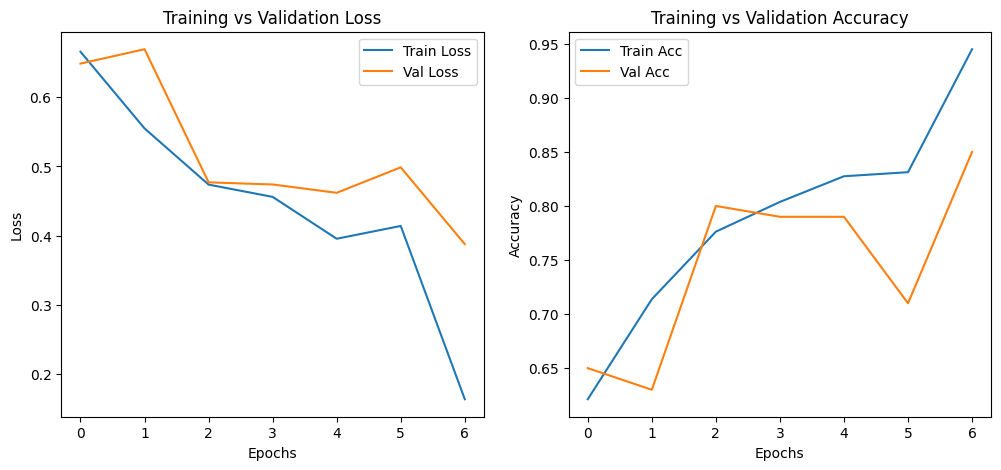

In [ ]:
# Save the model
torch.save(model.state_dict(), r"deepfake_detector.pth")
print("Model Saved!")

# Plot Loss and Accuracy Curves
plt.figure(figsize=(12, 5))

# Plot Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label="Train Loss")
plt.plot(range(num_epochs), val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accs, label="Train Acc")
plt.plot(range(num_epochs), val_accs, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.show()

In [116]:
import torch
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# Turn off gradients for evaluation
with torch.no_grad():
    for frames, labels in test_loader:
        frames = frames.to(device)
        labels = labels.to(device)

        outputs = model(frames)  # forward pass

        # If outputs are probabilities/sigmoid — threshold at 0.5
        preds = (outputs > 0.5).long()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute Accuracy
test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8100


In [117]:
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[45  5]
 [14 36]]


In [118]:
report = classification_report(all_labels, all_preds, target_names=["Real", "Fake"])
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

        Real       0.76      0.90      0.83        50
        Fake       0.88      0.72      0.79        50

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100

